# Tennis report

This notebook contains the results of training two agents to play tennis, using the provided Unity environment. It fulfills project 3 of Udacity's Deep Reinforcement Learning Nanodegree.

## Algorithm used
The algorithm used to train is a Multi Agent Deep Deterministic Policy Gradient algorithm (MADDPG). In this algorithm both agents have an actor and critic, the actor is a neural network used to choose an action based on the observation that agent recieves. The critic predicts the future rewards given the state and action taken. The actor uses only local information available to the agent, whilst the critic uses extra information, in this case the state observed and action taken by the other agent. This extra information is available during training, but at execution time the agents chooses actions based only on its' own observations.

To aid exploration, a gaussian noise process adds random noise to the actions chosen by the agents. 

## Parameters 

### Gaussian noise process
Mean $\mu =0$, and a standard deviation $\sigma$ starting at 0.5. Every episode the standard deviation is reduced ($\sigma_{i+1} = 0.990 * \sigma_{i})$

### Replay buffer
The replay buffer stores experiences (state, action, reward, next state, done). To learn, each agent randomly samples 256 of these experiences, and only the most recent 100000 experiences are stored.

### Actor network
The actor network for each agent is a fully connected neural network, with 2 hidden layers (size 256 and 128). Each hidden layer has an elu activation function, and the final layer has a tanh activation function. The optimiser used is an ADAM optimizer with learning rate 0.0001.

### Critic network
The critic network for each agent is a fully connected neural network, with 2 hidden layers (size 256 and 128). Each hidden layer has an elu activation function. The optimiser used is an ADAM optimizer with learning rate 0.0003.

### Miscellaneous
Before training starts the agents chooses random actions for 300 epsidoes. These are added to the replay buffer, but the network weights are not modified.
For each network there is a target network which is updated more slowly than the local network to stabilise training. Each step a soft update function is used to update the target network, with $\tau = 0.001$. Each step (every times agent recieves an experience), each agent performs 3 learn steps.
A discount rate of $\gamma = 0.99$ is used. 
The network weights are saved (checkpointed) every 100 episodes.

## Results
To train an agent from scratch, run the code contained in Tennis.ipynb.

Below the scores from a successful training run are shown (the agent was trained for 2500 episodes, of which 300 were random steps). The average score first crossed the pass threshold at about episode 1725.

In [1]:
import matplotlib.pyplot as plt
import pickle
import numpy as np

In [2]:
root = './checkpoints'
run_name = '20200612_1838'
episode_number = 'final'

score_history = pickle.load(open(root+'/'+run_name+'/ep'+episode_number+'_scores.pkl','rb'))
target_history = pickle.load(open('../amit_patel_scores.pkl','rb'))

In [3]:
def moving_average(a, n) :
    '''
    Calculates the moving average of an input list a, over a window of size n. 
    Returns the array of averages and the position of the final value in the window for each value
    '''
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    ave = ret[n - 1:] / n
    inds = list(range(n,len(ave)+n))
    return(ave,inds)

<IPython.core.display.Javascript object>


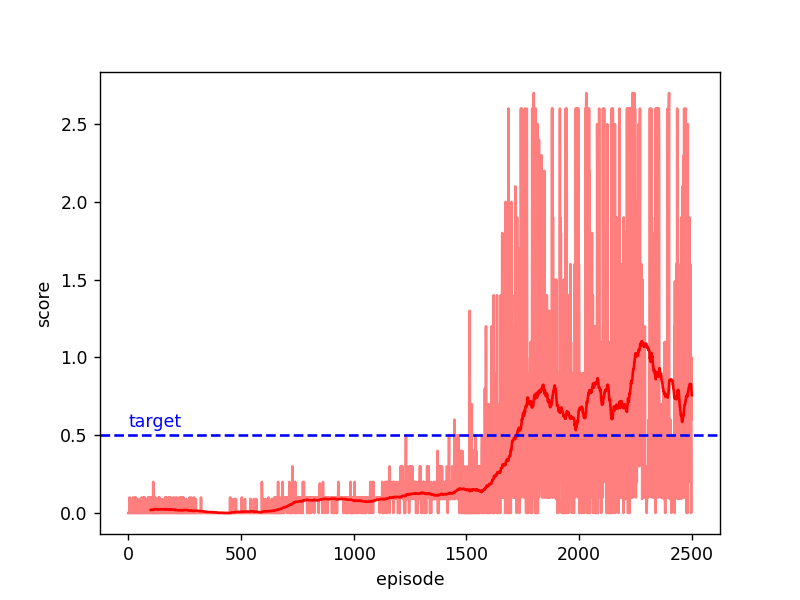

In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt

smooth_period = 100
colour='r'

fig, ax = plt.subplots()
ax.plot(score_history,color=colour,alpha=0.5)
ave, inds = moving_average(score_history,smooth_period)
ax.plot(inds,ave,color=colour)

ax.axhline(0.5,color='b',ls='--')
ax.text(x=0,y=0.55,s='target',color='b')

ax.set_xlabel('episode')
ax.set_ylabel('score')

plt.show()

## Get environment to test on

In [5]:
from unityagents import UnityEnvironment
import numpy as np
env = UnityEnvironment(file_name="./Tennis_Windows_x86_64/Tennis.exe")
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]

states = env_info.vector_observations
action_size = brain.vector_action_space_size
state_size = states.shape[1]
num_agents = len(env_info.agents)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


## Load trained agents
To see performance of a trained agent, we will load the saved weights from the file. The weights used here are those at episode 2200, as the average score at that episode appears greatest.

In [6]:
from models import *
from agent import *

#Define parameters
HIDDEN1_SIZE = 256
HIDDEN2_SIZE = 128
REPLAY_MAX_SIZE = 0 #Since we are only demonstrating not training there is no requirement for a replay buffer
BATCH_SIZE=0
ACTOR_LR, CRITIC_LR = 0, 0 #again, we are not training, so these learning rates can be zero
GAMMA, TAU, = 0, 0 #These parameters are only used for training
batch_norm=False

In [7]:
checkpoint_name = '2200'
checkpoint_location = './checkpoints/'
filename = '20200612_1838/'

maddpg = maddpg = MADDPG(state_size=state_size, action_size=action_size, num_agents=num_agents, 
                hidden1_size=HIDDEN1_SIZE, hidden2_size=HIDDEN2_SIZE, 
                max_replay_size=REPLAY_MAX_SIZE, batch_size=BATCH_SIZE,
                actor_lr=ACTOR_LR, critic_lr=CRITIC_LR, 
                gamma=GAMMA, tau=TAU, batch_norm=batch_norm)
#This is currently untrained


In [8]:
maddpg.load_checkpoint(name=filename, location=checkpoint_location, ep_no=checkpoint_name)
#Now trained

## Demonstration

In [9]:
demo_ep_no = 100
score_history = []


for i in range(demo_ep_no):                                      
    env_info = env.reset(train_mode=False)[brain_name]        
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = maddpg.get_actions(states)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           
        next_states = env_info.vector_observations         
        rewards = env_info.rewards                         
        dones = env_info.local_done                        
        scores += env_info.rewards                         
        states = next_states                               
        if np.any(dones):                                  
            break
    print('Episode %s, score = %.3f'%(i+1,np.max(scores)))
    score_history.append(np.max(scores))


Episode 1, score = 0.100
Episode 2, score = 0.100
Episode 3, score = 0.100
Episode 4, score = 0.700
Episode 5, score = 0.090
Episode 6, score = 2.500
Episode 7, score = 0.100
Episode 8, score = 0.200
Episode 9, score = 0.090
Episode 10, score = 0.100
Episode 11, score = 0.100
Episode 12, score = 0.100
Episode 13, score = 2.400
Episode 14, score = 0.090
Episode 15, score = 0.090
Episode 16, score = 0.100
Episode 17, score = 0.200
Episode 18, score = 2.600
Episode 19, score = 0.500
Episode 20, score = 1.300
Episode 21, score = 0.300
Episode 22, score = 0.200
Episode 23, score = 0.100
Episode 24, score = 0.100
Episode 25, score = 0.090
Episode 26, score = 0.100
Episode 27, score = 0.100
Episode 28, score = 1.100
Episode 29, score = 0.100
Episode 30, score = 2.300
Episode 31, score = 0.200
Episode 32, score = 0.100
Episode 33, score = 0.100
Episode 34, score = 2.100
Episode 35, score = 0.100
Episode 36, score = 0.400
Episode 37, score = 0.100
Episode 38, score = 1.300
Episode 39, score = 0

In [10]:
ave_score = np.mean(score_history)
print('The trained agent achieved an average score of %.3f over %s episodes'%(ave_score,demo_ep_no))

The trained agent achieved an average score of 0.652 over 100 episodes


## Possible improvements
Some improvements that could increase performance are:
* [Prioritized experience replay](https://cardwing.github.io/files/RL_course_report.pdf) - increase the probability of sampling experiences with large TD errors (i.e. experiences where the agent can learn more).
* [Stochastic weight averaging (SWA)](http://www.gatsby.ucl.ac.uk/~balaji/udl-camera-ready/UDL-24.pdf) aims to improve stability of RL by averaging weights along the performance trajectory. This should stop the agent 'forgetting' optimal strategies. In graph above the average score fluctuates significantly, particularly from episode 1800 onwards, so this strategy may prevent that.
* The use of [multiple critics per agent](https://ieeexplore.ieee.org/document/8616034) can reduce the dependance on just one critic network, and stabilise performance.